# **Neural Network in Numpy**


In this notebook, you will construct, initialize and train a simple neural network (multilayer perceptron) from scratch - using only numpy.

We will analyse a very easy dataset with our Network that looks like this:


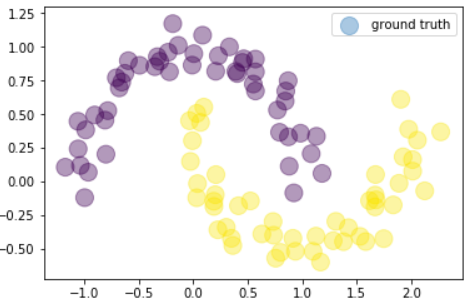               

Your solution code is supposed to give you an output which should look similiar to this:

 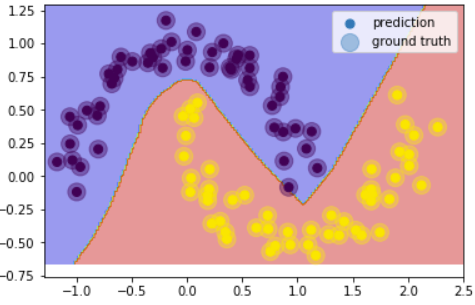


We define a classifier network consisting of:



*   A input layer with 2 input units
*   A single hiddel layer with n hidden units with ReLU activation
+   An output layer with 2 outputs using softmax activation

The network will look like this:

First, we import numpy, for the calculations, matplotlib for plotting and sklearn to get our dataset and split it in train- and testset:

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

%matplotlib inline

Keep in Mind: **A usage of additional libarys is prohibited!**

I defined some helper functions for you that you will use for example to plot our tasks:

In [2]:
def plot_history(history):
    '''plot loss over time'''
    lists = sorted(history.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists)
    labels=['train', 'test']
    for y_arr, label in zip(np.array(y).T, labels):
        plt.plot(x, y_arr, '-o', label=label)
    #plt.plot(x, y, '-o', label=labels)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_data(x, t_classes):
    '''scatter plot of 2D data points, colored according to ground truth classes'''
    plt.scatter(*x.T, c=t_classes, s=200, alpha=0.4, label='ground truth')
    plt.legend()

def plot_prediction(model, x, t_classes):
    '''scatter plot of 2D data points, with predictions (small) and ground truth labels (large)'''
    y = predict(model, x)
    plt.scatter(*x.T, c=y, s=50, alpha=1.0, label='prediction')
    plot_data(x, t_classes)
    #plt.scatter(*x.T, c=t_classes, s=200, alpha=0.4, label='ground truth')
    plt.legend()

def plot_prediction_with_decision_boundary(model, x, t_classes, resolution=200):
    '''scatter plot of 2D data points, with predictions (small) and ground truth labels (large),
    also including the decision boundary as background.'''

    # create lattice of points
    fig = plt.gcf()
    margin = 1.1
    xregion=[x[:,0].min()*margin, x[:,0].max()*margin]
    yregion=[x[:,1].min()*margin, x[:,1].max()*margin]
    xticks = np.linspace(*xregion, resolution)
    yticks = np.linspace(*yregion, resolution)
    p1,p2 = np.meshgrid(xticks, yticks)
    p = np.array([p1.flatten(), p2.flatten()]).T
    # predict class on all points of the lattice
    output = feed_forward(model, p)
    preds_bg = np.argmax(output[-1], axis=1)
    # plot prediction are colored surface
    _ = plt.contourf(p1, p2, preds_bg.reshape(len(xticks),len(yticks)), alpha=0.4, cmap='jet')
    plot_prediction(model, x, t_classes)

def to_onehot_encoding(y):
    '''Convert from class values to one-hot notation'''
    assert y.ndim == 1
    num_samples = len(y)
    num_classes = np.max(y)+1
    onehot = np.zeros((num_samples, num_classes), np.uint8)
    onehot[np.arange(num_samples), y] = 1
    return onehot

#Create the dataset
**Now we create the data and see what it looks like:**

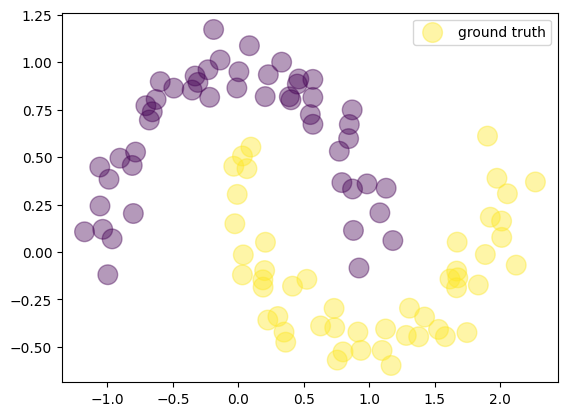

In [3]:
'''x:           Data Points
   t_classes:   Class Labels
'''

x, t_classes = datasets.make_moons(n_samples=100, noise=0.1, random_state=42)
#x, t_classes = datasets.make_circles(n_samples=100, factor=0.7, noise=0.1, random_state=42)
#x, t_classes = datasets.make_blobs(n_samples=100, centers=2, cluster_std=1.0 center_box=[-2, 2], random_state=42)
t = to_onehot_encoding(t_classes)

plot_data(x, t_classes)

# Implement the network functions

**In the next steps we will define a classifier network consisting of:**


* input units of a size depended on our data
* n hidden units with ReLU activation
* 2 outputs using softmax activation (to decide between 2 classes)

We use categorical crossentropy as our loss *function*

**Task 1: Call t_classes parameter to see that our labels are allready encoded as numbers:**

In [4]:
t_classes

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

**Task 2: Define Relu and its derivative**

In [5]:
def relu(x):
    """
    Compute the relu() of x

    Arguments:
    x -- A scalar or numpy array of any size

    Return:
    r -- relu(x)
    """
    
    if x < 0:
        return 0
    
    return x 

def relu_derivative(x):
    """
    Compute the derivative of relu(x)

    Arguments:
    x -- A scalar or numpy array of any size

    Return:
    dr -- relu(x)
    """
    return 0

**Task 3: Define the softmax function!** (use the np.sum with axis=1 and keepdims=True)

In [6]:
def softmax(x):
    """
    Compute the softmax of x

    Arguments:
    x -- A scalar or numpy array of any size

    Return:
    s -- softmax(x)
    """
    return 1/(1+np.exp(-x))

**Task 4: Define the cross entropy function!**

$\text{CE}(t, \hat{y}) = - \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} t_{i,j} \cdot \log(\hat{y}_{i,j})$

In [7]:
def cross_entropy(t, y_pred):
    """
    Compute the negative crossentropy between a ground truth t and the predictions y_pred

    Arguments:
    t -- A scalar or numpy array of any size

    Return:
    c -- the CE between t and y_pred
    """
    return 1 / len(t) * np.sum(np.sum(t * np.log(y_pred), 2), 1)

**Task 5: Initialise the weights and biases, using "He" initialization!**

n_in = number of input neurons in the layer


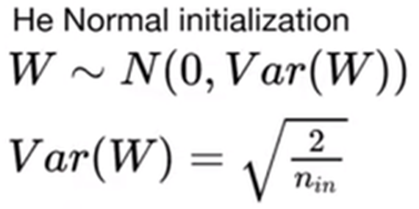

In [ ]:
# n_in = number of neurons in the layer
def build_model(n_inputs, n_hidden_units, n_outputs):
    """
    Initialize the weights and biases of the network
    Use  np.random.rand / np.zeros and np.sqrt!

    Arguments:
    n_inputs-- A scalar or numpy array of any size
    n_hidden_units -- A scalar or numpy array of any size
    n_outputs -- A scalar or numpy array of any size

    Return:
    model -- a dictionary with the "He" initialized weights and biases
    """

    model = {}
    # First Layer weights and biases
    model['W1'] = ''YOUR CODE GOES HERE''
    model['b1'] = np.sqrt(2/n_inputs)
    # Second Layer weights and biases
    model['W2'] = ''YOUR CODE GOES HERE''
    model['b2'] = ''YOUR CODE GOES HERE''
    return model

**Task 6: Define forward pass**

In [ ]:
def feed_forward(model, x):
    """
    Define the forward path using the initialized weights and biases stored in
    the "model" dict

    Arguments:
    model -- A dict of with the weights and biases
    x     -- A scalar or numpy array of any size

    Intermediats:
    z1 -- The values after application of the neuron function in the first
          hidden layer

    Return:
    a1 -- The hidden layer outputs after the application of the relu-transfer
          function (activations)
    output -- The output layer activations after the application of the softmax
          transfer function (activations)
    """

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Calculate Activations hidden layer
    z1 = 'YOUR CODE GOES HERE'
    a1 = 'YOUR CODE GOES HERE'

    # Activations of output layer
    z2 = 'YOUR CODE GOES HERE'

    output = 'YOUR CODE GOES HERE'

    return a1, output



These are 3 functions to make decision based on the models output using argmax aswell as to calculate the loss and the accuracy:

In [ ]:
def predict(model, x):
    #prediction is one forward pass through the model, returns class predictions (max probable classes)
    _, output = feed_forward(model, x)
    return np.argmax(output, axis=1)

def calculate_loss(y_true, y_pred):
    num_samples = y_true.shape[0]
    return cross_entropy(y_true, y_pred) / num_samples

def accuracy(y_true, y_pred):
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    return (np.abs(y_true - y_pred) < 0.5 ).all(axis=1).mean()

**We can define the backprob for this simple network like this:**

In [ ]:
def backprop(model, y_true, x, a1, output):

    # error for each output units. shape = (n_samples, n_outputs)
    # dL/dz = dL/dy . dy/dz = derivative_xe . derivative_softmax
    delta3 = (output - y_true)  # See on the bottom: https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1


    # error for hidden units. shape = (n_samples, n_hidden_units)
    # dL/dz = dL/do . dy/dz
    delta2 = np.dot( delta3, model['W2'].T) * relu_derivative(a1)

    # dL / dW2
    dW2 = np.dot( a1.T, delta3)
    # dL / db2
    db2 = np.sum( delta3, axis=0, keepdims=0)

    # dL / dW1
    dW1 = np.dot( x.T, delta2)
    # dL / db1
    db1 = np.sum( delta2, axis=0, keepdims=0)

    return dW1, db1, dW2, db2

**Task 7: Implement the gradient descent to update the weights and biases:**

In [ ]:
def update_params(model, learning_rate, deltas):
    """
    Update weights and biases according to gradient descent given the learning_rate, the model with the weights
    and the gradients stored in "deltas".

    Arguments:
    model -- A dict of with the weights and biases
    deltas -- A matrix with the updated gradients
    learning_rate   -- A scalar or numpy array of any size

    Return:
    model -- The updated dict of with the weights and biases
    """


    # update weights and biases according to gradient descent given the learning_rate, the model with the weights
    # and the gradients stored in "deltas".

    dW1, db1, dW2, db2 = deltas

    model['W1'] -= 'YOUR CODE GOES HERE'
    model['b1'] -= 'YOUR CODE GOES HERE'
    model['W2'] -= 'YOUR CODE GOES HERE'
    model['b2'] -= 'YOUR CODE GOES HERE'

    return model

#**Define the Trainingloop**
Now we can define the training loop, that we will call in a second. See that we
use all our predefined functions in this definition:

In [ ]:
def fit(model, x, t, n_epochs, learning_rate, x_test=None, t_test=None, threshold=0.01):

    history = {}
    for i in range(n_epochs):

        # feed forward: predict output
        a1, output = feed_forward(model, x)

        # backpropagation: calculate gradients
        deltas = backprop(model, t, x, a1, output)

        # optimization: update weights and biases
        model = update_params(model, learning_rate, deltas)


        if i % 1000 == 0:
            # calculate loss
            loss = calculate_loss(t, output)

            # accuracy
            acc = accuracy(t, output)

            loss_test = None
            if x_test is not None and t_test is not None:
                a1, output = feed_forward(model, x_test)
                loss_test = calculate_loss(t_test, output)
                val_acc = accuracy(t_test, output)
                print("epochs {: >5d} : loss = {:.2f}, val_loss = {:.2f}, acc = {:.2f}, val_acc = {:.2f}, ".format(i, loss, loss_test, acc, val_acc))
            else:
                print("epochs {: >5d} : loss = {:.2f}, acc = {:.2f}".format(i, loss, acc))
            history[i] = (loss, loss_test)

            if loss < 0.01:
                break

    return history

# Split the data and build the model!
**It is time to touch some data and and get their shape to to build our 1 Layer MLP with 128 neurons.**

In [ ]:
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.33, random_state=42)

num_features = x_train.shape[-1]
num_samples  = x_train.shape[0]
num_classes  = t_train.shape[-1]
print("Shape of inputs  = ", x.shape)
print("Shape of targets = ", t_train.shape)

n_inputs       = num_features
n_hidden_units = 128
n_outputs      = num_classes
model = build_model(n_inputs, n_hidden_units, n_outputs)

**We can finally call our fitting function and hand over the parameters:**

In [ ]:
history = fit(model, x_train, t_train,
                n_epochs=10000, learning_rate=0.001,
                x_test=x_test, t_test=t_test)

**This plot will show the development of our loss over our training period. If you did everything correct it will decgrease untill a saturation is reached.**

In [ ]:
_ = plot_history(history)

**This pre defined helper function will plot the results of our prediction.
The small solid points are predictions and the large transparent points represent ground truth.**

In [ ]:
plot_prediction(model, x, t_classes)
plt.show()

**Now it is time for your final solution and finish the assignment! Plot prediction with decision boundary:**

In [ ]:
plot_prediction_with_decision_boundary(model, x, t_classes)
plt.show()